<a href="https://colab.research.google.com/github/waelrash1/predictive_analytics_DT302/blob/main/Lab_PCR_and_PLS_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This lab on PCS and PLS is a python adaptation of p. 256-259 of "Introduction to Statistical Learning with Applications in R" by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani. Original adaptation by J. Warmenhoven, updated by R. Jordan Crouser at Smith College for SDS293: Machine Learning (Spring 2016).

# 6.7.1 Principal Components Regression

Principal components regression (PCR) can be performed using the `PCA()`
function, which is part of the `sklearn` library. In this lab, we'll apply PCR to the `Hitters`
data, in order to predict `Salary`. As in previous labs, we'll start by ensuring that the missing values have
been removed from the data:

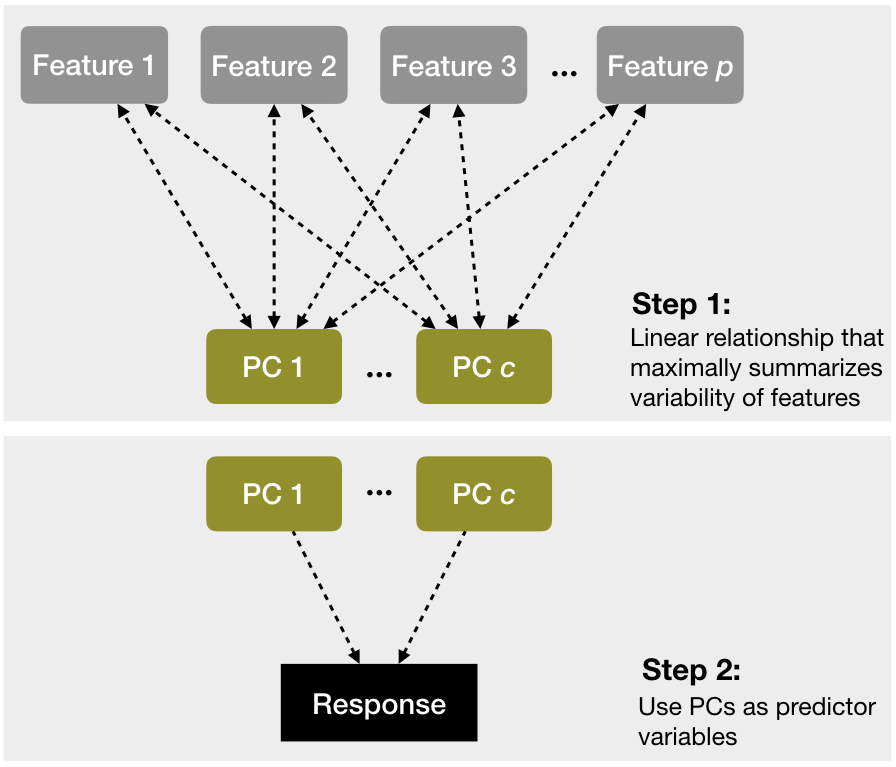

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error




In [2]:
url='https://raw.githubusercontent.com/selva86/datasets/master/Hitters.csv'
df = pd.read_csv(url).dropna()
df.info()
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 
dtypes: float64

Let's set up our data:

In [3]:
y = df.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')

# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)

Unfortunately `sklearn` does not have an implementation of PCA and regression combined like the `pls`, package in R: https://cran.r-project.org/web/packages/pls/vignettes/pls-manual.pdf so we'll have to do it ourselves.

We'll start by performing Principal Components Analysis (PCA), remembering to scale the data:

In [4]:
pca = PCA() # create a PCA model
X_reduced = pca.fit_transform(scale(X)) # train the PCA model of scaled data X-- unsupervised
pd.DataFrame(pca.components_.T) # components tansposed matrix



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.198290,-0.383784,0.088626,0.031967,0.028117,-0.070646,0.107044,0.269810,-0.012183,0.145621,0.097328,0.103150,-0.039850,0.306248,0.532433,-0.510331,0.139342,-0.106790,0.053777
1,0.195861,-0.377271,0.074032,0.017982,-0.004652,-0.082240,0.130026,0.388722,-0.061604,0.130476,0.014433,0.121009,0.003593,0.210616,-0.023442,0.720168,-0.167363,0.043568,-0.097782
2,0.204369,-0.237136,-0.216186,-0.235831,0.077660,-0.149646,-0.505833,-0.226278,0.127422,-0.351111,-0.202190,-0.314852,-0.108689,-0.001353,0.355455,0.200408,0.047702,-0.058377,-0.024805
3,0.198337,-0.377721,-0.017166,-0.049942,-0.038536,-0.136660,0.201764,0.114518,-0.171230,0.032245,-0.312187,-0.321700,-0.381219,-0.266583,-0.468300,-0.220518,0.140946,0.047050,0.059145
4,0.235174,-0.314531,-0.073085,-0.138985,0.024299,-0.111675,-0.319440,0.005082,0.131146,-0.172233,0.243415,0.347752,0.440143,-0.007486,-0.461468,-0.237366,-0.106688,0.063998,0.019351
5,0.208924,-0.229606,0.045636,-0.130615,-0.032495,-0.019480,0.558420,-0.623342,-0.021438,-0.120940,0.176393,0.185278,0.041020,-0.237940,0.176549,0.102541,-0.042240,0.006655,-0.018030
6,0.282575,0.262402,0.034581,0.095312,-0.010361,0.033243,-0.012029,0.138314,-0.010645,-0.512507,0.191547,0.354594,-0.605010,0.086080,-0.066239,-0.024135,-0.095586,-0.085780,0.020309
7,0.330463,0.192904,0.083574,0.091114,0.011716,0.024377,0.012057,0.147030,-0.054657,-0.101137,-0.030238,-0.062390,0.148585,-0.168155,0.157743,-0.056835,0.182264,0.720128,-0.409277
8,0.330742,0.182899,0.086251,0.083751,0.008524,0.029395,0.020000,0.194547,-0.094925,-0.077220,-0.029848,-0.083475,0.266807,-0.290311,0.136632,0.110442,0.031999,-0.003477,0.770272
9,0.318979,0.126297,-0.086272,-0.074278,0.032652,-0.040780,-0.228830,-0.249490,0.167949,0.650534,0.079790,0.074114,-0.330107,0.039828,-0.009399,-0.026816,-0.291752,0.254301,0.166104


In [5]:
expLianedVariance=(pca.explained_variance_/pca.explained_variance_.sum())*100
expLianedVarianceCum=expLianedVariance.cumsum()
pd.DataFrame( expLianedVarianceCum, expLianedVariance)

,0
38.314240,38.314240
21.841076,60.155315
10.686359,70.841675
8.192520,79.034194
5.256081,84.290275
4.344504,88.634779
3.628108,92.262888
2.700156,94.963043
1.319648,96.282691
0.972722,97.255413


In [6]:
expLianedVariance.size


19

(0.0, 20.0)

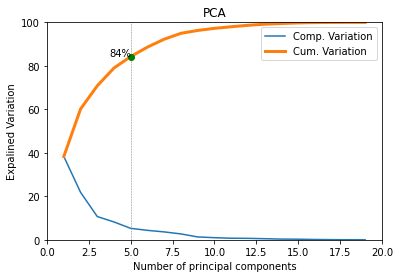

In [7]:
xlabel=range(1, expLianedVariance.size+1)
xlabel=np.reshape( np.asarray(list(xlabel)), (19,))
N_PC_sel=5
variance_N_PC= expLianedVarianceCum[N_PC_sel-1]
plt.figure( )

plt.plot(list(xlabel),expLianedVariance, label='Comp. Variation')
plt.plot(list(xlabel),expLianedVarianceCum, label = 'Cum. Variation', linewidth=3)
#Vertical line at the selected no of components
plt.axvline(x=N_PC_sel, linestyle='dashed',linewidth=.5, color='grey')
# add apoint
plt.plot(N_PC_sel,variance_N_PC, color='green', marker='o')
plt.text(N_PC_sel,variance_N_PC,"{0:.0%}".format(variance_N_PC/100.0), horizontalalignment='right')

plt.legend()
plt.title('PCA')
plt.xlabel('Number of principal components')
plt.ylabel('Expalined Variation')
plt.ylim([0,100])
plt.xlim([0,20])

Let's print out the first few variables of the first few principal components:

In [ ]:
pd.DataFrame(pca.components_.T).loc[:4,:5]

,0,1,2,3,4,5
0,0.198290,-0.383784,0.088626,0.031967,0.028117,-0.070646
1,0.195861,-0.377271,0.074032,0.017982,-0.004652,-0.082240
2,0.204369,-0.237136,-0.216186,-0.235831,0.077660,-0.149646
3,0.198337,-0.377721,-0.017166,-0.049942,-0.038536,-0.136660
4,0.235174,-0.314531,-0.073085,-0.138985,0.024299,-0.111675


Now we'll perform 10-fold cross-validation to see how it influences the MSE:

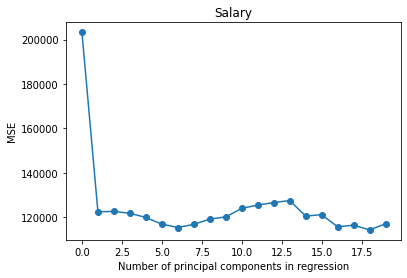

In [9]:
# 10-fold CV, with shuffle
from sklearn.model_selection import KFold
n = len(X_reduced)
kf_10 = KFold( n_splits=10, shuffle=True, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(regr, np.ones((n,1)), y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*cross_val_score(regr, X_reduced[:,:i], y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
# Plot results    
plt.plot(mse, '-o')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

We see that the smallest cross-validation error occurs when $M = 18$ components
are used. This is barely fewer than $M = 19$, which amounts to
simply performing least squares, because when all of the components are
used in PCR no dimension reduction occurs. However, from the plot we
also see that the cross-validation error is roughly the same when only one
component is included in the model. This suggests that a model that uses
just a small number of components might suffice.

We'll do a little math to get the amount of variance explained by adding each consecutive principal component:

In [ ]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([38.31, 60.15, 70.84, 79.03, 84.29, 88.63, 92.26, 94.96, 96.28,
       97.25, 97.97, 98.64, 99.14, 99.46, 99.73, 99.88, 99.95, 99.98,
       99.99])

We'll dig deeper into this concept in Chapter 10, but for now we can think of this as the amount of information about the predictors or the response that is captured using $M$ principal components. For example,
setting $M = 1$ only captures 38.31% of all the variance, or information, in
the predictors. In contrast, using $M = 6$ increases the value to 88.63%. If
we were to use all $M = p = 19$ components, this would increase to 100%.

Now let's perform PCA on the training data and evaluate its test set
performance:

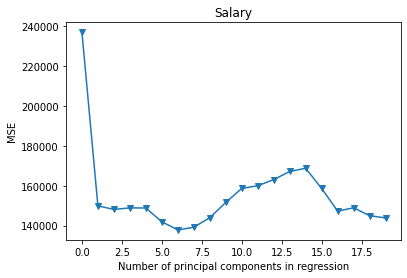

In [10]:
pca2 = PCA()

# Split into training and test sets
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

# Scale the data
X_reduced_train = pca2.fit_transform(scale(X_train))
n = len(X_reduced_train)

# 10-fold CV, with shuffle
kf_10 = KFold( n_splits=10, shuffle=True, random_state=1)

mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(regr, np.ones((n,1)), y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*cross_val_score(regr, X_reduced_train[:,:i], y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

We find that the lowest cross-validation error occurs when $M = 6$
components are used. Now we'll see how it performs on the test data and compute the test MSE as follows:

In [11]:
X_reduced_test = pca2.transform(scale(X_test))[:,:7]

# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train[:,:7], y_train)

# Prediction with test data
pred = regr.predict(X_reduced_test)
mean_squared_error(y_test, pred)

111994.42273636986

This test set MSE is competitive with the results obtained using ridge regression
and the lasso. However, as a result of the way PCR is implemented,
the final model is more difficult to interpret because it does not perform
any kind of variable selection or even directly produce coefficient estimates.

# 6.7.2 Partial Least Squares

Scikit-learn `PLSRegression` gives same results as the `pls` package in R when using `method='oscorespls'`. However, the standard method used is `'kernelpls'`, which we'll use here. Feel free to try out both.

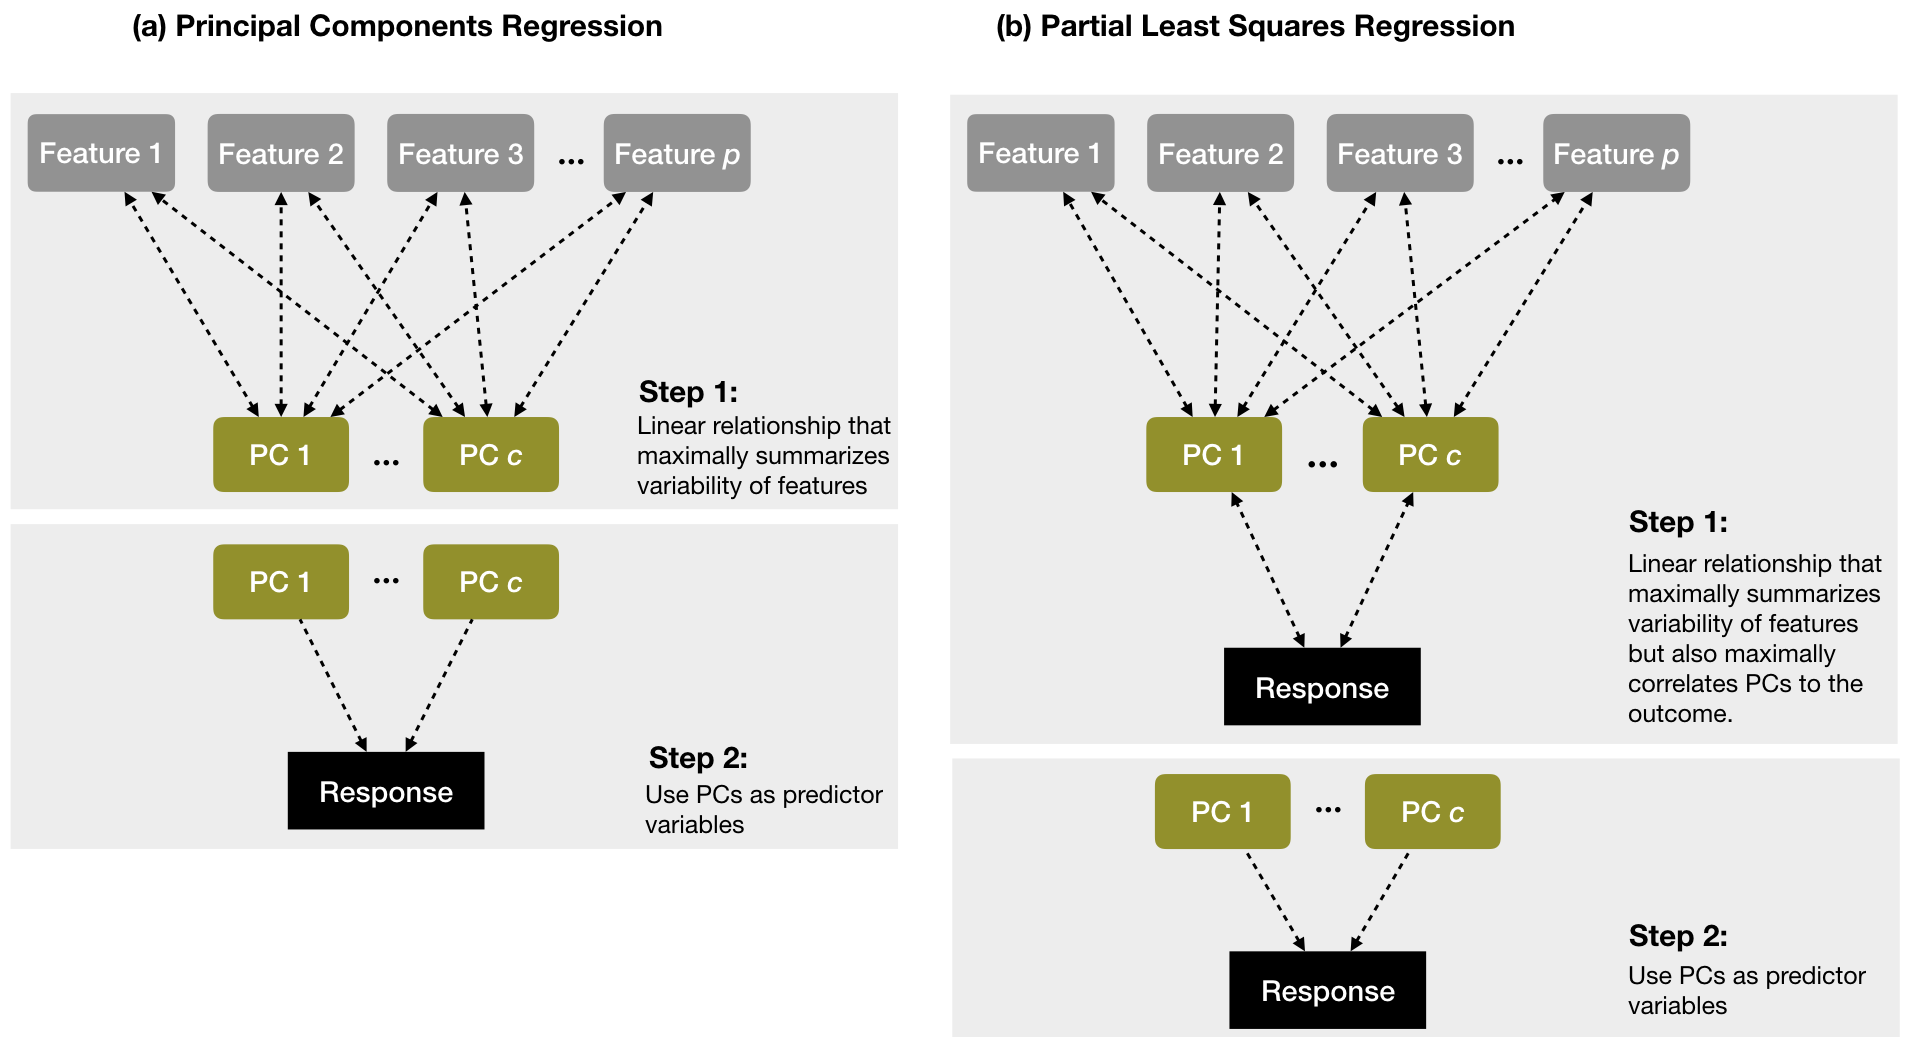

(-1.0, 19.9)

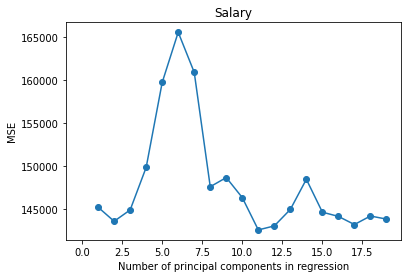

In [13]:
n = len(X_train)

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits=10, shuffle=True, random_state=1)

mse = []

for i in np.arange(1, 20):
    pls = PLSRegression(n_components=i)
    score = cross_val_score(pls, scale(X_train), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(-score)

# Plot results
plt.plot(np.arange(1, 20), np.array(mse), '-o')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1)

The lowest cross-validation error occurs when only $M = 2$ partial least
squares dimensions are used. We now evaluate the corresponding test set
MSE:

In [14]:
pls = PLSRegression(n_components=2)
pls.fit(scale(X_train), y_train)

mean_squared_error(y_test, pls.predict(scale(X_test)))

104838.51042760801

The test MSE is again comparable to the test MSE
obtained using ridge regression, the lasso, and PCR.

The test MSE is again comparable to the test MSE
obtained using ridge regression, the lasso, and PCR.

# Your turn!
Now it's time to test out these approaches (PCR and PLS) and evaluation methods (validation set, cross validation) on other datasets. You may want to work with a team on this portion of the lab.
You may use any of the datasets included in ISLR, or choose one from the UCI machine learning repository. Download a dataset, and try to determine the optimal set of parameters to use to model it! You are free to use the same dataset you used in Labs 9 and 10, or you can choose a new one.

In [ ]:
# Your code here

To get credit for this lab, post your responses to the following questions:
 - Which dataset did you choose?
 - What was your response variable (i.e. what were you trying to model)?
 - Which method performed better?
 - Which method do you think tends to have lower bias?
 - Which method do you think tends to have lower variance?
 
